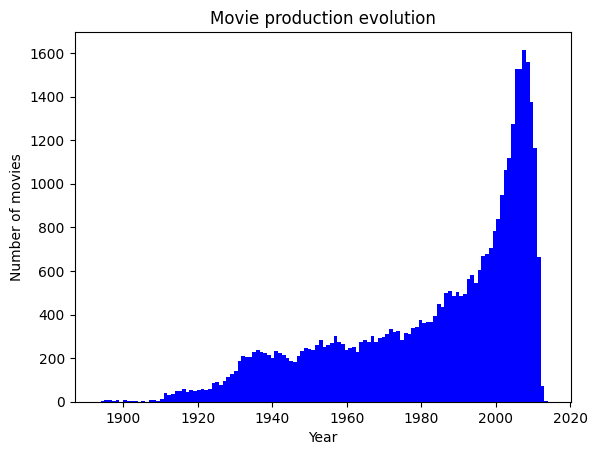

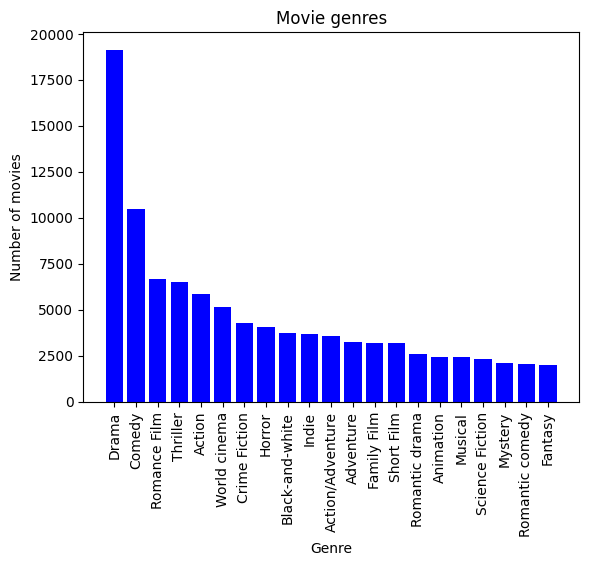

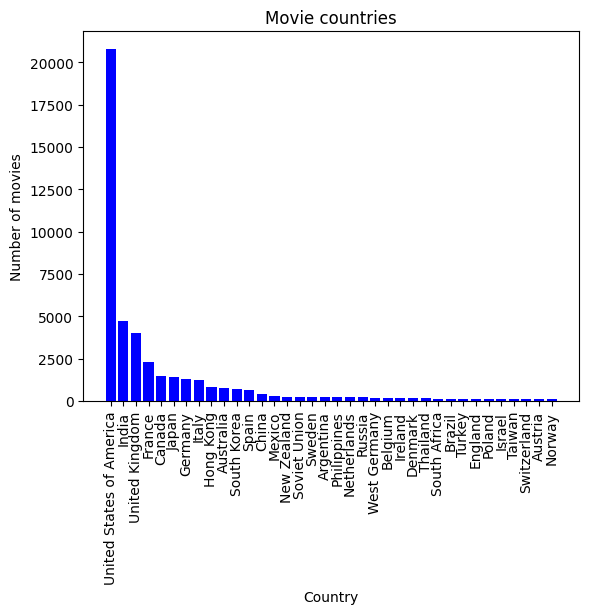

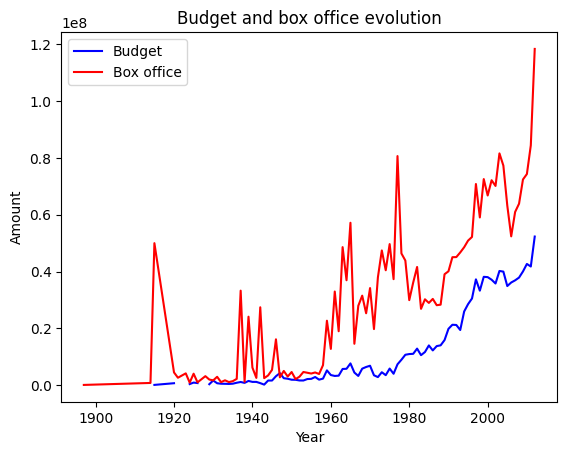

/var/folders/07/9l9kqd013xjdlz8_0b2__8xr0000gq/T/ipykernel_69250/3662793107.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["decade"] = df["release_year"].apply(lambda x: int(x/10)*10)
/var/folders/07/9l9kqd013xjdlz8_0b2__8xr0000gq/T/ipykernel_69250/3662793107.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["million"] = df["movie_box_office_revenue"].apply(lambda x: int(x/1000000)*1000000)
/var/folders/07/9l9kqd013xjdlz8_0b2__8xr0000gq/T/ipykernel_69250/3662793107.py:116: SettingWithCopyWarn

TypeError: object of type 'float' has no len()

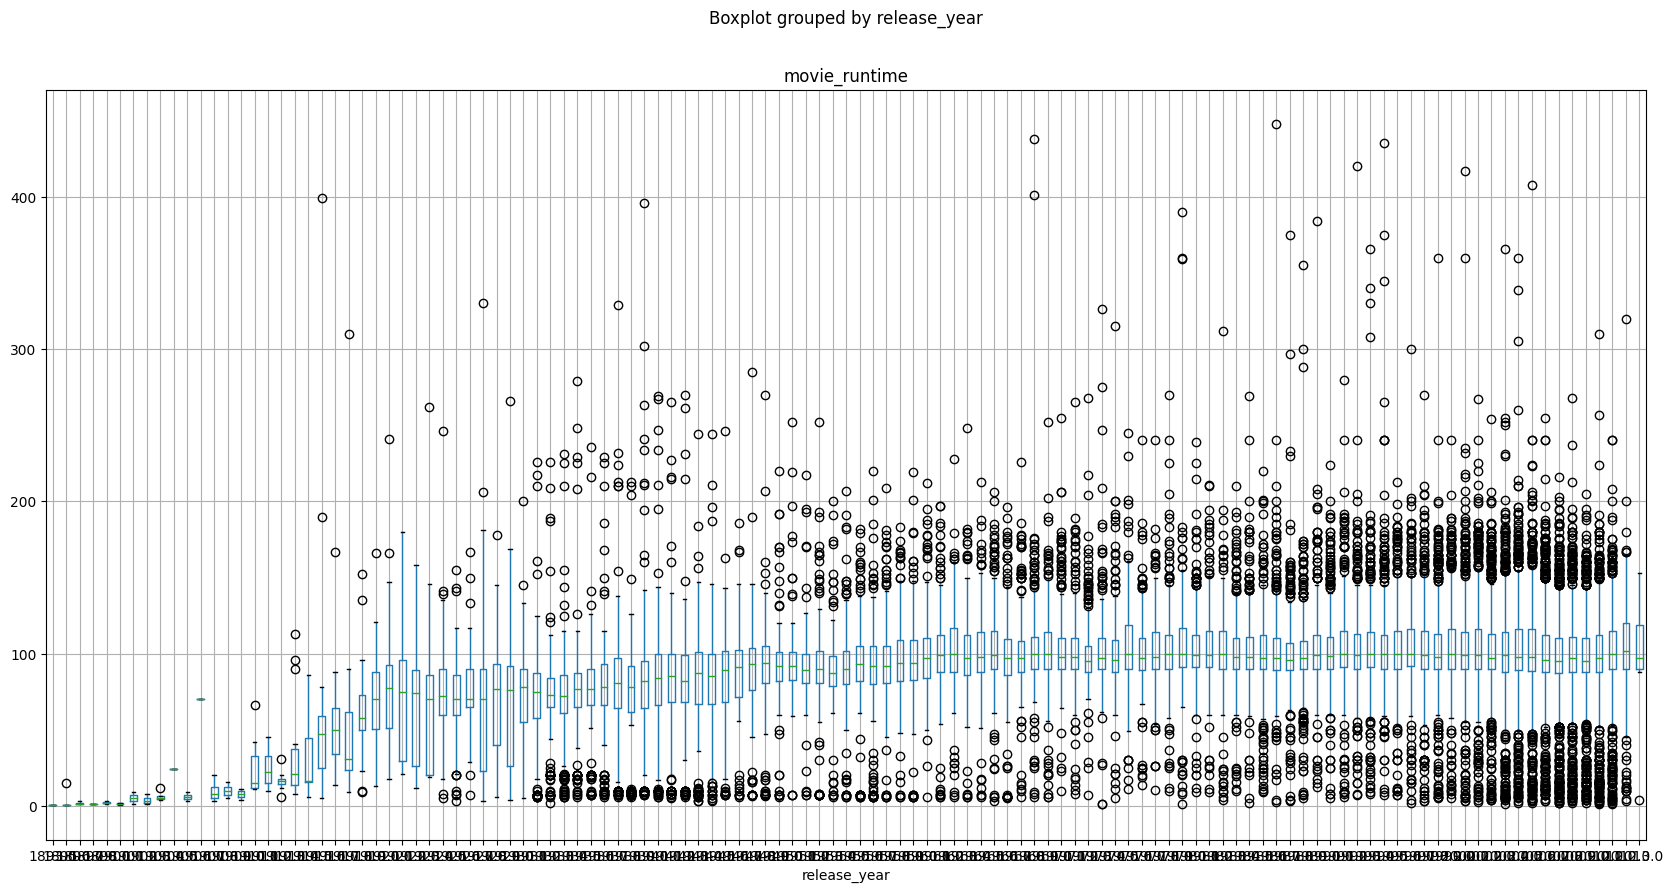

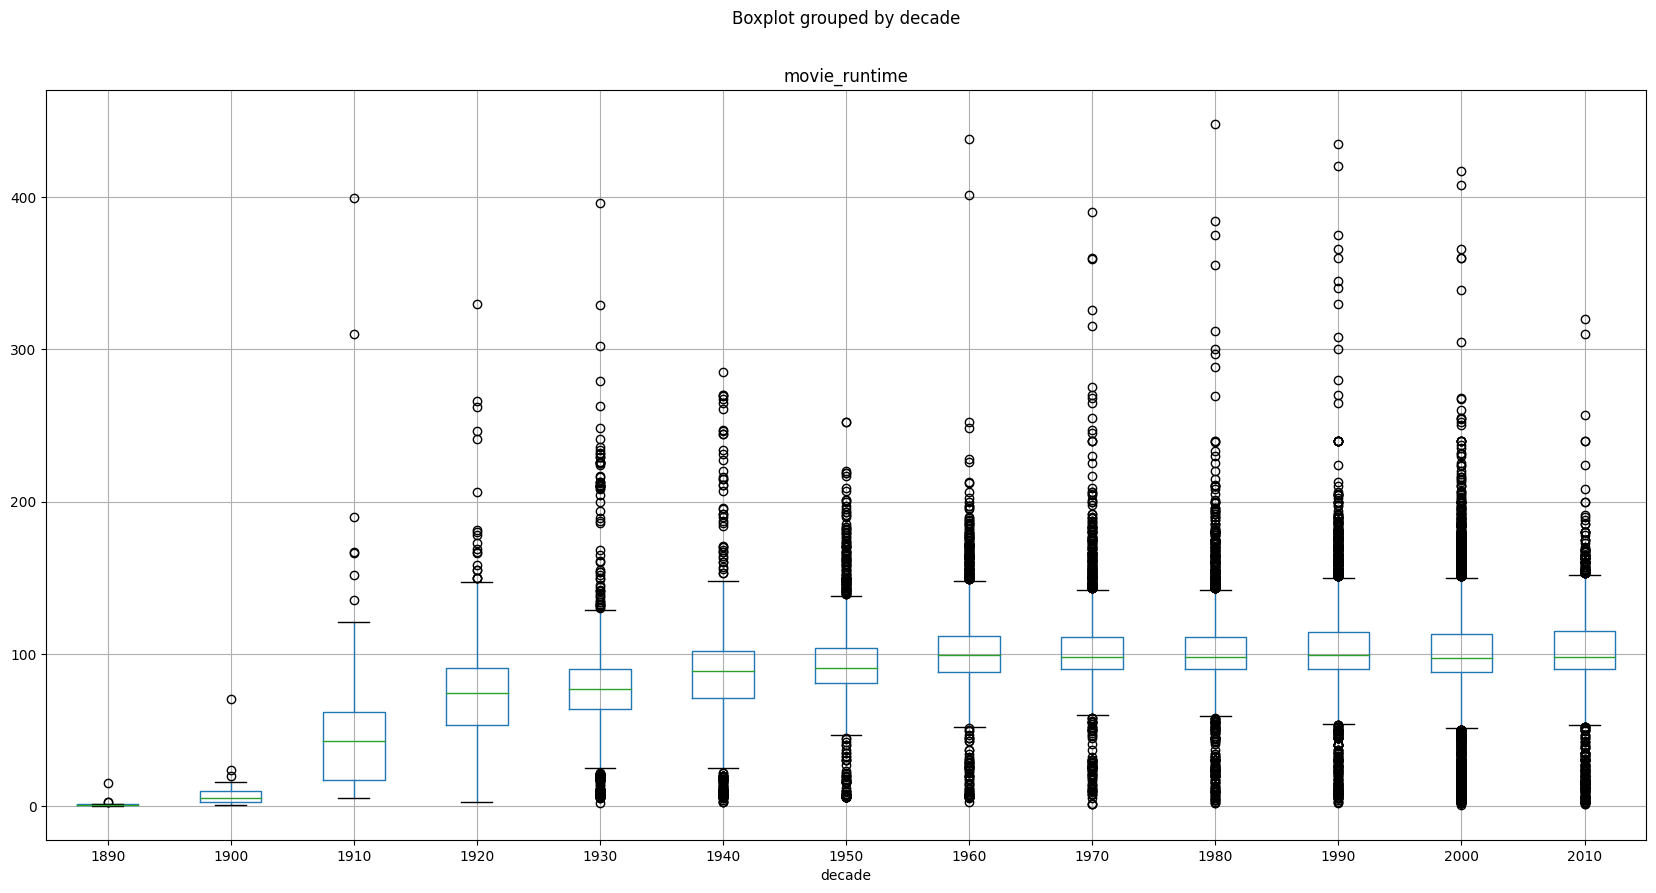

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

# REMOVE THIS
import json

FOLDER_PATH = 'data/'
DATA_COLUMNS = ['wiki_movie_id', 'freebase_movie_id', 'movie_name',
       'movie_box_office_revenue', 'movie_runtime', 'languages', 'countries',
       'genres', 'imdb_id', 'cast', 'rating', 'votes', 'budget', 'plot',
       'characters_names', 'main_character', 'release_year']
df = pd.read_csv(FOLDER_PATH + 'movie_processed.csv', names=DATA_COLUMNS, header=0, index_col=0)
df.head()
# 2.1 movie production evolution
fig, ax = plt.subplots()
ax.hist(df["release_year"], bins=(2014-1893+1), color="blue")
ax.set_xlabel("Year")
ax.set_ylabel("Number of movies")
ax.set_title("Movie production evolution")
plt.show()
df["release_year"].describe()

genres = df.genres.apply(lambda film: [genre for genre in literal_eval(film)]).explode().value_counts()
genres = genres[genres > 2000]
fig, ax = plt.subplots()
ax.bar(genres.index, genres.values, color="blue")
ax.set_xlabel("Genre")
ax.set_ylabel("Number of movies")
ax.set_title("Movie genres")
plt.xticks(rotation=90)
plt.show()
countries = df.countries.apply(lambda film: [country for country in literal_eval(film)]).explode().value_counts()
countries = countries[countries > 100]
fig, ax = plt.subplots()
ax.bar(countries.index, countries.values, color="blue")
ax.set_xlabel("Country")
ax.set_ylabel("Number of movies")
ax.set_title("Movie countries")
plt.xticks(rotation=90)
plt.show()
## for this one we need the revenue fetch from the API

fig, ax = plt.subplots()
box_office = df[df["movie_box_office_revenue"].notna()]
budget_by_year = box_office.groupby("release_year")["budget"].mean()
box_office_world_by_year = box_office.sort_values(["release_year"]).groupby("release_year")["movie_box_office_revenue"].mean()
ax.plot(budget_by_year.index, budget_by_year.values, color="blue", label="Budget")
ax.plot(box_office_world_by_year.index, box_office_world_by_year.values, color="red", label="Box office")
ax.set_xlabel("Year")
ax.set_ylabel("Amount")
ax.set_title("Budget and box office evolution")
ax.legend()
plt.show()
### Analysis for research question n*1
# We remove the movies with no release date since it will be impossible to include them in the time evolution (2619 movies removed)
df_r1 = df[df["release_year"].notna()]
#### Runtime evolution
# Cleaning runtime data

# soldiers of freedom is indeed a 6h movie
# Unsung heroes is actually 98 min long
# Swallow the sun is a TV series so indeed really long...
# heimat est une serie de films...
# once a eagle is a mini serie
df_r1.sort_values("movie_runtime", ascending=False)[["movie_name", "movie_runtime"]].head(30)

# Remove outliers
# We remove movies with a runtime higher than 6h as it corresponds mostly to TV series, mini series and errors (removed 20 movies)
df_runtime = df_r1[df_r1["movie_runtime"] < 450]
def group_by_decade(df):
    df["decade"] = df["release_year"].apply(lambda x: int(x/10)*10)
    return df

df_runtime.boxplot(column="movie_runtime", by="release_year", figsize=(20, 10))

df_runtime_decade = group_by_decade(df_runtime)
df_runtime_decade.boxplot(column="movie_runtime", by="decade", figsize=(20, 10))


# We remove the movies without value for the box office (26830 movies removed, 7461 kept)
df_runtime = df_runtime[df_runtime["movie_box_office_revenue"].notna()] 
#df_runtime.boxplot(column="movie_runtime", by="movie_box_office_revenue", figsize=(20, 10))

#df_runtime.sort_values("movie_box_office_revenue", ascending=False)[["movie_name", "movie_runtime", "movie_box_office_revenue"]].head(50)

def group_by_thousand(df):
    df["thousand"] = df["movie_box_office_revenue"].apply(lambda x: int(x/1000)*1000)
    return df

def group_by_million(df):
    df["million"] = df["movie_box_office_revenue"].apply(lambda x: int(x/1000000)*1000000)
    return df

#df_runtime_thousand = group_by_thousand(df_runtime)
#df_runtime_thousand.boxplot(column="movie_runtime", by="thousand", figsize=(20, 10))

df_runtime_million = group_by_million(df_runtime)
#df_runtime_million.boxplot(column="movie_runtime", by="million", figsize=(20, 10))


# box_offices = df_runtime_million.movie_box_office_revenue.apply(lambda x: int(x/1000000)*1000000).value_counts()
# fig, ax = plt.subplots()
# ax.bar(box_offices.index, box_offices.values, color="blue")
# ax.set_xlabel("Box office")
# ax.set_ylabel("Number of movies")
# ax.set_title("Movie box office")
# plt.xticks(rotation=90)
# plt.show()
# box_offices

#### Number of character evolution
# Clean cast data
# We remove the movies with no cast (removed 17703 movies)
df_cast = df_r1[df_r1["cast"].notna()]
df_cast["cast_length"] = df_cast["cast"].apply(lambda cast: len(cast))
#df_cast.boxplot(column="cast_length", by="release_year", figsize=(20, 10))
type(df_cast["cast"].head(1).values[0])

#### Ratio Men/Women evolution
# TODO: try to do a graph nb of women in cast by year (or by decade) and another one with nb of men
def get_nb_actors(cast):
    return len(cast)

def get_nb_female_actors(cast):
    return None
#### Character type
COLOMNS_NAMES_TV_TROPES = [
    "character_type",
    "object"
]
df_tvtropes = pd.read_csv(FOLDER_PATH + 'tvtropes.clusters.txt', sep='\t', header=None, names=COLOMNS_NAMES_TV_TROPES)

# Treats the object column to turn it into multiple columns
df_tvtropes["character_name"] = df_tvtropes.apply(lambda x: json.loads(x["object"])["char"], axis=1)
df_tvtropes["movie_name"] = df_tvtropes.apply(lambda x: json.loads(x["object"])["movie"], axis=1)
df_tvtropes["freebase_id"] = df_tvtropes.apply(lambda x: json.loads(x["object"])["id"], axis=1)
df_tvtropes["actor_name"] = df_tvtropes.apply(lambda x: json.loads(x["object"])["actor"], axis=1)
df_tvtropes.drop("object", axis=1, inplace=True)

df_tvtropes.head()
#need box office value for each movie, and then take mean of box office for each character type
# WE remove the movie with no box office value (removed 27030 movies) 34617-7587=27030
df_box_office = df[df["movie_box_office_revenue"].notna()]
df_box_office = df_box_office.movie_box_office_revenue.apply(lambda x: x[0] if len(x) > 0 else None) 
df_character_type = df_tvtropes.copy()
df_character_type["movie_box_office_revenue"] = df_character_type["movie_name"].apply(lambda movie_name: df_box_office[df_box_office["movie_name"] == movie_name]["movie_box_office_revenue"].values)
df_character_type.groupby("character_type").count()
# df_character_type["movie_box_office_revenue"] = df_character_type["movie_box_office_revenue"].apply(lambda x: x[0])




In [31]:
df_character_type.head()

,character_type,character_name,movie_name,freebase_id,actor_name,movie_box_office_revenue
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,[177977226.0]
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,[38087756.0]
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,[48063435.0]
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,[2200000.0]
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,[196567262.0]


In [58]:
df_character_type["movie_box_office_revenue"] = df_character_type["movie_box_office_revenue"].apply(lambda x: x[0] if len(x) > 0 else None) 
# import numpy as np
# df_character_type.groupby("character_type")
#.aggregate(np.mean)
# , "character_name", "movie_name", "freebase_id", "actor_name"

In [63]:
df_character_type.head(10)

,character_type,character_name,movie_name,freebase_id,actor_name,movie_box_office_revenue
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,177977226.0
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,38087756.0
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,48063435.0
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,2200000.0
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,196567262.0
5,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,/m/0jzx78,Harrison Ford,786636033.0
6,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Raiders of the Lost Ark,/m/0k294p,Harrison Ford,389925971.0
7,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Temple of Doom,/m/0jzx9b,Harrison Ford,333107271.0
8,adventurer_archaeologist,Evelyn Carnahan-O'Connell,The Mummy,/m/0k5yzc,Rachel Weisz,415933406.0
9,arrogant_kungfu_guy,Han,Enter the Dragon,/m/02vd8hn,Shih Kien,NaN


/var/folders/07/9l9kqd013xjdlz8_0b2__8xr0000gq/T/ipykernel_69250/1092458557.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_character_type.groupby("character_type").mean().sort_values("movie_box_office_revenue", ascending=False).plot(kind="bar", figsize=(20, 10))


<AxesSubplot: xlabel='character_type'>

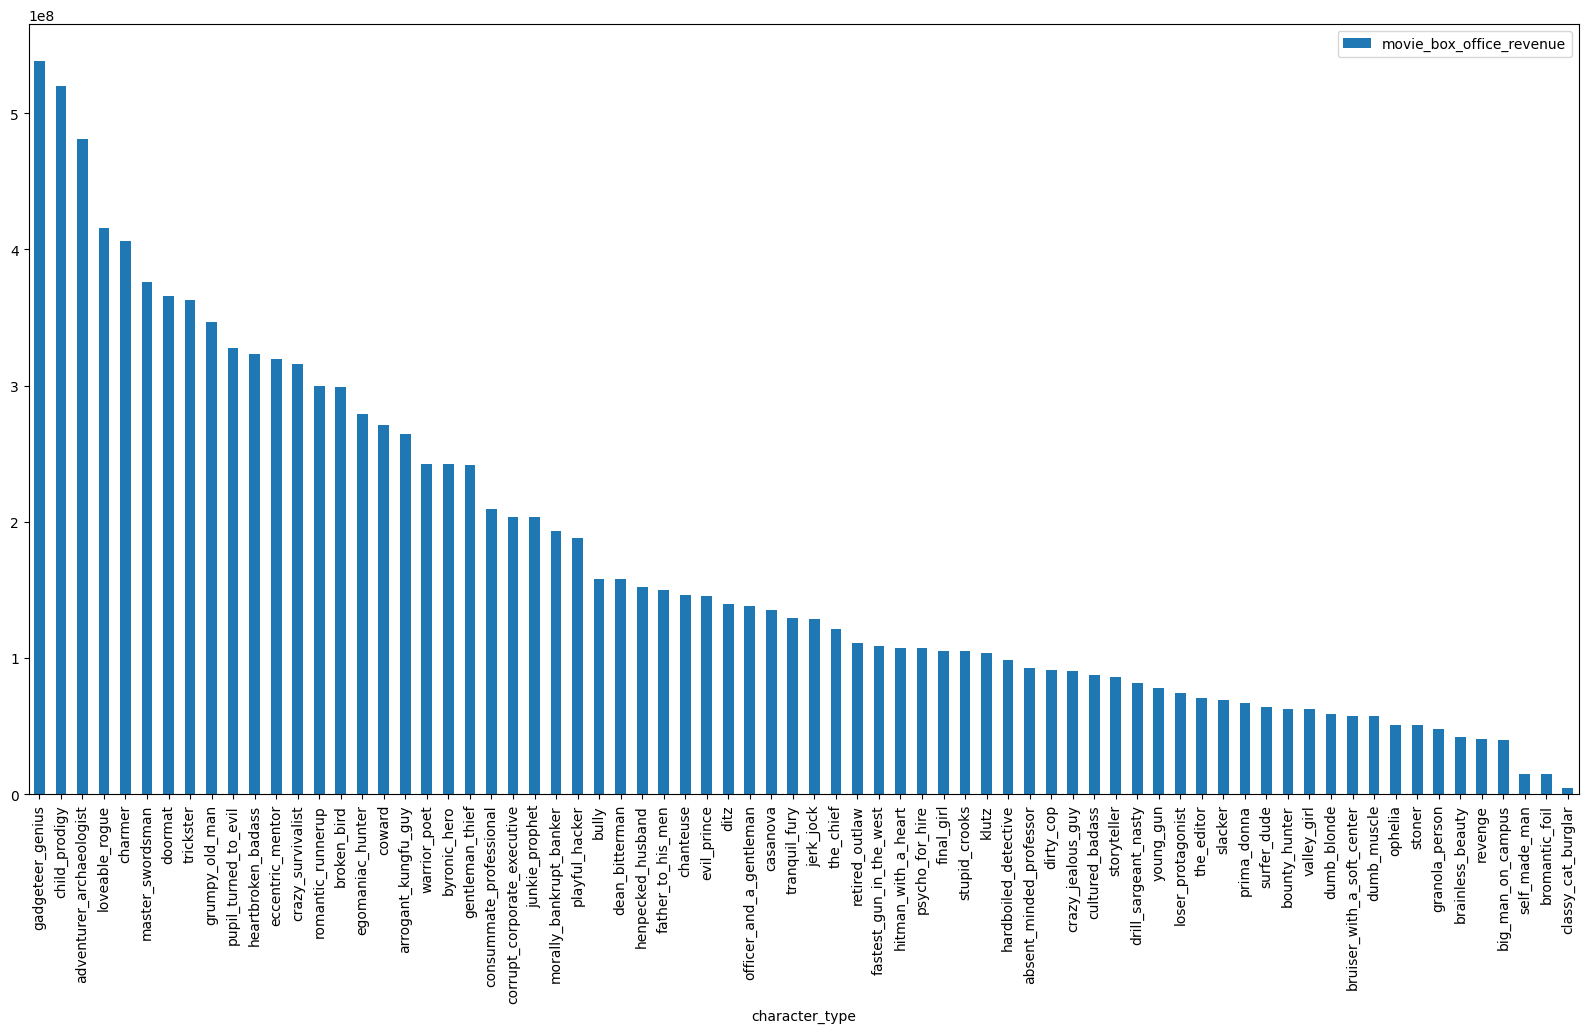

In [66]:
df_character_type.groupby("character_type").mean().sort_values("movie_box_office_revenue", ascending=False).plot(kind="bar", figsize=(20, 10))